# Task 1: Graph Cut Segmentation
##### Aye Khin Khin Hpone (Yolanda Lim)_125970
---

## Objective
Implementation of graph-based image segmentation using the GrabCut algorithm with automatic bounding box detection.

## Methodology
1. Generate bounding boxes using pretrained YOLOv11 object detector
2. Apply GrabCut segmentation with varying iterations (1, 3, 5)
3. Analyze qualitative and quantitative differences
4. Visualize original images, masks, foreground extraction, and overlays

## Dataset
- **Images**: asm-1.jpg, asm-2.jpg
- **Target**: Person segmentation from background

## Approach

### Two-Stage Pipeline
**Stage 1: Object Detection**
- YOLOv11 pretrained model for automatic person detection
- Generates bounding box coordinates

**Stage 2: Graph-Based Segmentation**
- OpenCV GrabCut algorithm for foreground/background separation
- Iterative refinement using graph cuts and Gaussian Mixture Models

In [ ]:
# -----------------------------------------------------------
# Check GPU availability on puffer server
# -----------------------------------------------------------
!nvidia-smi

import torch

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

# Check current device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Sat Nov  8 04:38:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:84:00.0 Off |                  N/A |
| 24%   37C    P8             24W /  250W |     854MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Import Required Libraries

In [ ]:
import os
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
%matplotlib inline
plt.style.use('default')

# Check current working directory
print("="*60)
print("ENVIRONMENT SETUP")
print("="*60)
print(f"Working Directory: {os.getcwd()}")
print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"OpenCV Version: {cv.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

print("\nAvailable Images:")
for file in os.listdir():
    if file.endswith(('.jpg', '.png', '.jpeg')):
        print(f"  - {file}")
print("="*60)

ENVIRONMENT SETUP
Working Directory: /home/jupyter-st125970/ass3
Python Version: 3.12.6
PyTorch Version: 2.8.0+cu128
OpenCV Version: 4.12.0
CUDA Available: True

Available Images:
  - asm-1.jpg
  - asm-2.jpg


## 2. Object Detection Model Setup

Load YOLOv11 pretrained model for automatic person detection. The model is pre-trained on COCO dataset (80 object classes) and will be used to generate bounding boxes around detected persons.

In [2]:
# Install/update ultralytics library for YOLOv11
try:
    from ultralytics import YOLO
    print("Ultralytics library already installed")
except ImportError:
    print("Installing ultralytics library...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ultralytics"])
    from ultralytics import YOLO
    print("Ultralytics library installed successfully")

# Load YOLOv11 pretrained model
# Using yolo11n (nano version) for faster inference, or yolo11s (small) for better accuracy
print("\nLoading YOLOv11 model...")
model = YOLO('yolo11n.pt')  # Options: yolo11n, yolo11s, yolo11m, yolo11l, yolo11x

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"\n{'='*60}")
print(f"Model: YOLOv11 (Nano)")
print(f"Device: {device.upper()}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(f"Running on CPU (slower but functional)")
print(f"{'='*60}")

Ultralytics library already installed

Loading YOLOv11 model...

Model: YOLOv11 (Nano)
Device: CUDA
GPU: NVIDIA GeForce RTX 2080 Ti
CUDA Version: 12.8
GPU Memory: 11.54 GB


### Note on Pretrained Model

The YOLOv11 model is pre-trained on the COCO dataset. The model file contains learned weights and requires no additional dataset downloads. Person detection corresponds to class ID 0 in the COCO label set.

## 3. Load and Visualize Input Images

Loaded asm-1.jpg: (428, 639, 3)
Loaded asm-2.jpg: (427, 640, 3)


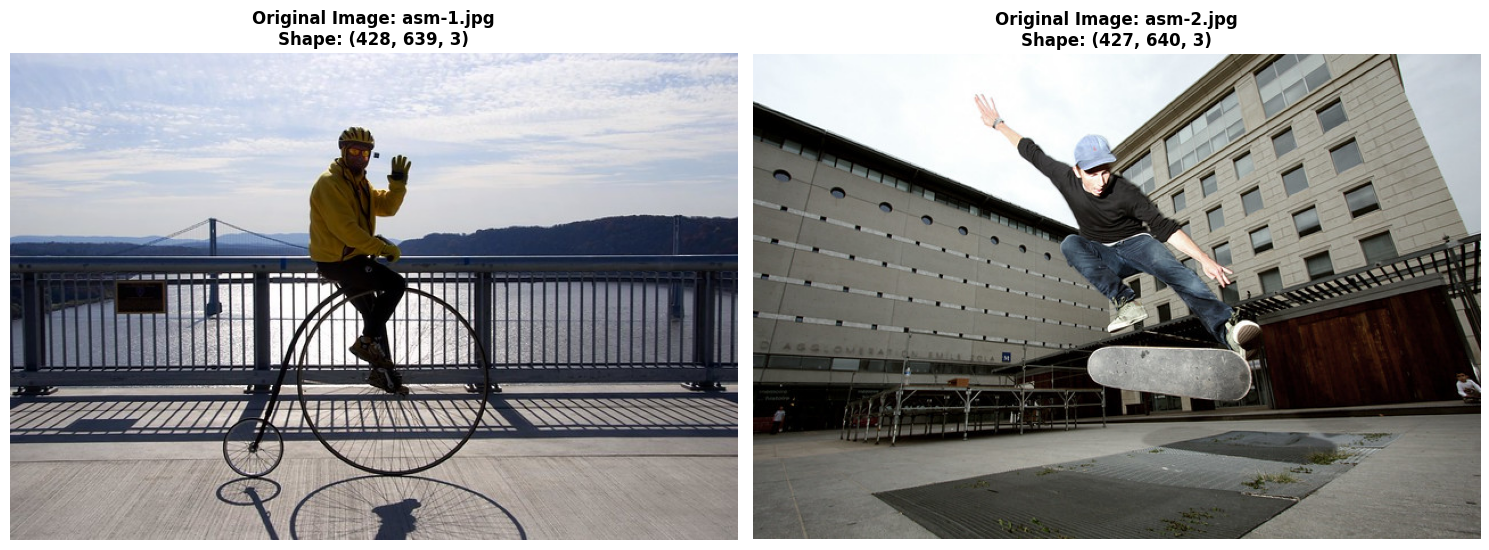

In [6]:
image_files = ['asm-1.jpg', 'asm-2.jpg']

# Load images
images = {}
for img_file in image_files:
    img = cv.imread(img_file)
    if img is None:
        print(f"Error: Could not load {img_file}")
        print(f"Attempted path: {os.path.abspath(img_file)}")
        continue
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images[img_file] = {
        'original': img,
        'rgb': img_rgb,
        'shape': img.shape
    }
    print(f"Loaded {img_file}: {img.shape}")

# Visualize original images
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for idx, img_file in enumerate(image_files):
    axes[idx].imshow(images[img_file]['rgb'])
    axes[idx].set_title(f'Original Image: {img_file}\nShape: {images[img_file]["shape"]}', 
                        fontsize=12, fontweight='bold')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

## 4. Person Detection and Bounding Box Generation

Apply YOLOv11 model to detect persons in both images and extract bounding box coordinates for subsequent segmentation.

In [7]:
def detect_person(image_rgb, model, confidence_threshold=0.5):
    """
    Detect person in image using YOLOv11
    
    Args:
        image_rgb: RGB image (numpy array)
        model: YOLOv11 model (Ultralytics)
        confidence_threshold: Minimum confidence score for detection
    
    Returns:
        bounding_boxes: List of bounding boxes [(x1, y1, x2, y2), ...]
        confidences: List of confidence scores
    """
    # Run inference with YOLOv11
    results = model(image_rgb, verbose=False)
    
    # Extract bounding boxes and confidences
    bboxes = []
    confidences = []
    
    # YOLOv11 returns results in a different format
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get class ID and confidence
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            
            # Filter for 'person' class (class 0 in COCO dataset where YOLOv11 was trained)
            # COCO has 80 classes: person=0, bicycle=1, car=2, etc.
            if cls == 0 and conf >= confidence_threshold:
                # Get bounding box coordinates
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                
                bboxes.append((x1, y1, x2, y2))
                confidences.append(conf)
    
    return bboxes, confidences

# Detect persons in both images
print("\n" + "="*60)
print("PERSON DETECTION USING YOLOv11")
print("="*60)

detections = {}
for img_file in image_files:
    print(f"\nProcessing {img_file}...")
    bboxes, confs = detect_person(images[img_file]['rgb'], model)
    detections[img_file] = {
        'bboxes': bboxes,
        'confidences': confs
    }
    print(f"  ✓ Detected {len(bboxes)} person(s)")
    for i, (bbox, conf) in enumerate(zip(bboxes, confs)):
        print(f"    Person {i+1}: BBox={bbox}, Confidence={conf:.3f}")

print("\n" + "="*60)


PERSON DETECTION USING YOLOv11

Processing asm-1.jpg...
  ✓ Detected 1 person(s)
    Person 1: BBox=(261, 64, 353, 301), Confidence=0.887

Processing asm-2.jpg...
  ✓ Detected 1 person(s)
    Person 1: BBox=(193, 35, 448, 269), Confidence=0.924



### 4.1 Visualize Detected Bounding Boxes

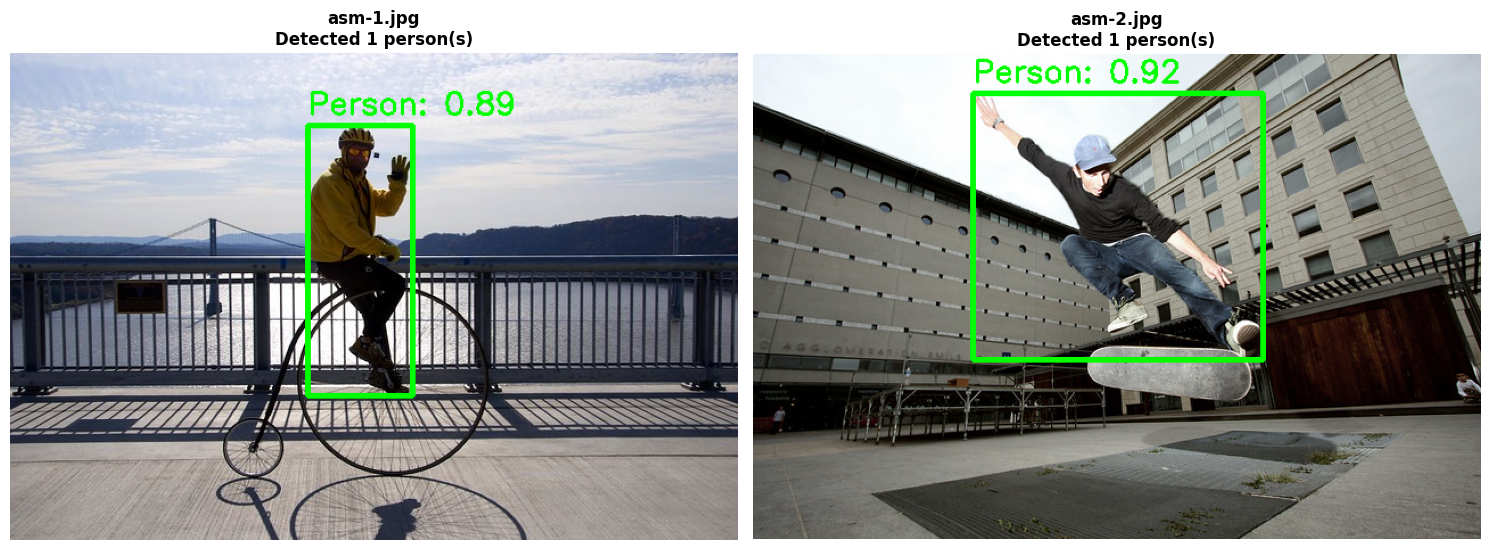

In [8]:
# Visualize detections with bounding boxes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, img_file in enumerate(image_files):
    img_display = images[img_file]['rgb'].copy()
    bboxes = detections[img_file]['bboxes']
    confs = detections[img_file]['confidences']
    
    # Draw bounding boxes
    for bbox, conf in zip(bboxes, confs):
        x1, y1, x2, y2 = bbox
        cv.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv.putText(img_display, f'Person: {conf:.2f}', (x1, y1-10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    axes[idx].imshow(img_display)
    axes[idx].set_title(f'{img_file}\nDetected {len(bboxes)} person(s)', 
                        fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 5. GrabCut Segmentation Implementation

### 5.1 Algorithm Overview

GrabCut is a graph-based segmentation technique that uses:
- Graph cuts for energy minimization
- Gaussian Mixture Models for foreground/background color modeling
- Iterative refinement for boundary optimization

**Implementation Parameters:**
- Initialization: Bounding box from YOLOv11 object detector
- Iterations: 1, 3, and 5 (for comparative analysis)
- Mode: cv.GC_INIT_WITH_RECT (rectangle initialization)
- Output: Binary mask (foreground=1, background=0)

**Expected Behavior:**
- Iteration 1: Initial segmentation based on color distributions within/outside bounding box
- Iterations 3-5: Iterative refinement of boundary using graph cuts and GMM updates
- Convergence: Algorithm typically stabilizes after 3-5 iterations (minimal pixel changes)

### 5.2 GrabCut Function Implementation

In [9]:
def apply_grabcut(image, bbox, iterations):
    """
    Apply GrabCut algorithm to segment foreground from background
    
    Args:
        image: Input image (BGR format)
        bbox: Bounding box (x1, y1, x2, y2)
        iterations: Number of iterations for GrabCut
    
    Returns:
        mask: Segmentation mask
        foreground: Foreground-only image
        overlay: Original image with segmented foreground overlaid
    """
    # Convert bbox format from (x1, y1, x2, y2) to (x, y, w, h)
    x1, y1, x2, y2 = bbox
    rect = (x1, y1, x2 - x1, y2 - y1)
    
    # Initialize mask and models (required by GrabCut)
    mask = np.zeros(image.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Apply GrabCut algorithm
    cv.grabCut(image, mask, rect, bgd_model, fgd_model, 
               iterations, cv.GC_INIT_WITH_RECT)
    
    # Create binary mask: foreground = 1, background = 0
    # Combine definite foreground (1) and probable foreground (3)
    mask_binary = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 1, 0).astype('uint8')
    
    # Extract foreground
    foreground = image.copy()
    foreground = foreground * mask_binary[:, :, np.newaxis]
    
    # Create overlay (foreground on white background)
    overlay = np.ones_like(image) * 255
    overlay = overlay * (1 - mask_binary[:, :, np.newaxis]) + foreground
    
    return mask_binary, foreground, overlay


def calculate_metrics(mask):
    """
    Calculate quantitative metrics for segmentation quality
    
    Args:
        mask: Binary segmentation mask
    
    Returns:
        Dictionary with metrics
    """
    total_pixels = mask.shape[0] * mask.shape[1]
    foreground_pixels = np.sum(mask)
    background_pixels = total_pixels - foreground_pixels
    
    return {
        'total_pixels': total_pixels,
        'foreground_pixels': int(foreground_pixels),
        'background_pixels': int(background_pixels),
        'foreground_ratio': foreground_pixels / total_pixels,
        'background_ratio': background_pixels / total_pixels
    }

### 5.3 Run GrabCut with Different Iterations (1, 3, 5)

In [ ]:
# Define iteration counts for analysis
ITERATION_COUNTS = [1, 3, 5]

# Run GrabCut with different iteration counts
iteration_counts = ITERATION_COUNTS

# Store results
grabcut_results = {}

for img_file in image_files:
    print(f"\n{'='*60}")
    print(f"Processing: {img_file}")
    print(f"{'='*60}")
    
    image = images[img_file]['original']
    bboxes = detections[img_file]['bboxes']
    
    if len(bboxes) == 0:
        print(f"No person detected in {img_file}, skipping...")
        continue
    
    # Use the first detected person (highest confidence)
    bbox = bboxes[0]
    print(f"Using bounding box: {bbox}")
    
    grabcut_results[img_file] = {}
    
    for iter_count in iteration_counts:
        print(f"\n  Running GrabCut with {iter_count} iteration(s)...")
        
        # Apply GrabCut
        mask, foreground, overlay = apply_grabcut(image, bbox, iter_count)
        
        # Calculate metrics
        metrics = calculate_metrics(mask)
        
        # Store results (convert to RGB for visualization efficiency)
        grabcut_results[img_file][iter_count] = {
            'mask': mask,
            'foreground': cv.cvtColor(foreground, cv.COLOR_BGR2RGB),
            'overlay': cv.cvtColor(overlay, cv.COLOR_BGR2RGB),
            'metrics': metrics
        }
        
        # Print metrics
        print(f"    Foreground pixels: {metrics['foreground_pixels']:,} ({metrics['foreground_ratio']*100:.2f}%)")
        print(f"    Background pixels: {metrics['background_pixels']:,} ({metrics['background_ratio']*100:.2f}%)")

print(f"\n{'='*60}")
print("GrabCut processing completed!")
print(f"{'='*60}")


Processing: asm-1.jpg
Using bounding box: (261, 64, 353, 301)

  Running GrabCut with 1 iteration(s)...
    Foreground pixels: 14,156 (5.18%)
    Background pixels: 259,336 (94.82%)

  Running GrabCut with 3 iteration(s)...
    Foreground pixels: 14,107 (5.16%)
    Background pixels: 259,385 (94.84%)

  Running GrabCut with 5 iteration(s)...
    Foreground pixels: 13,779 (5.04%)
    Background pixels: 259,713 (94.96%)

Processing: asm-2.jpg
Using bounding box: (193, 35, 448, 269)

  Running GrabCut with 1 iteration(s)...
    Foreground pixels: 30,720 (11.24%)
    Background pixels: 242,560 (88.76%)

  Running GrabCut with 3 iteration(s)...
    Foreground pixels: 23,625 (8.64%)
    Background pixels: 249,655 (91.36%)

  Running GrabCut with 5 iteration(s)...
    Foreground pixels: 23,620 (8.64%)
    Background pixels: 249,660 (91.36%)

GrabCut processing completed!


## 6. Results Visualization

### 6.1 Segmentation Results by Image

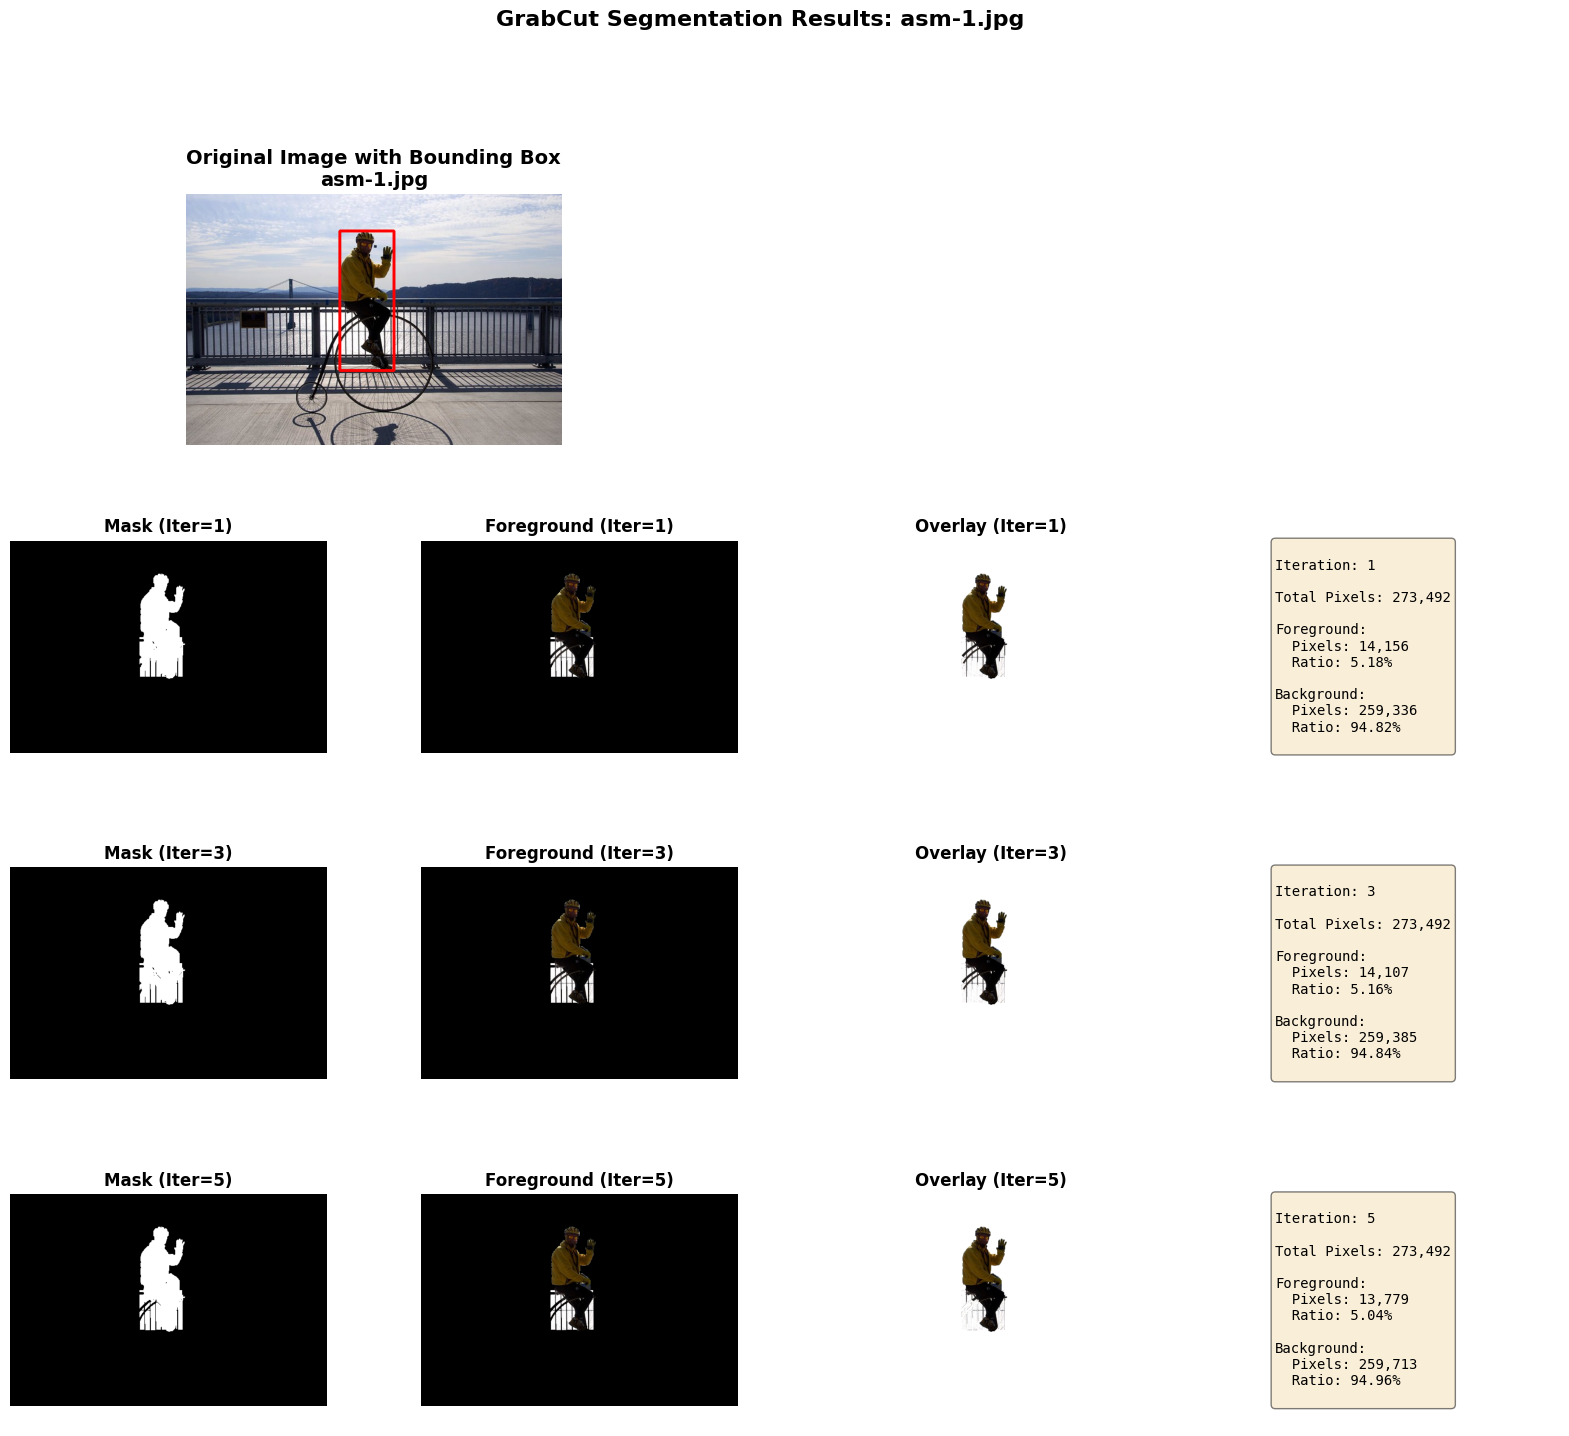

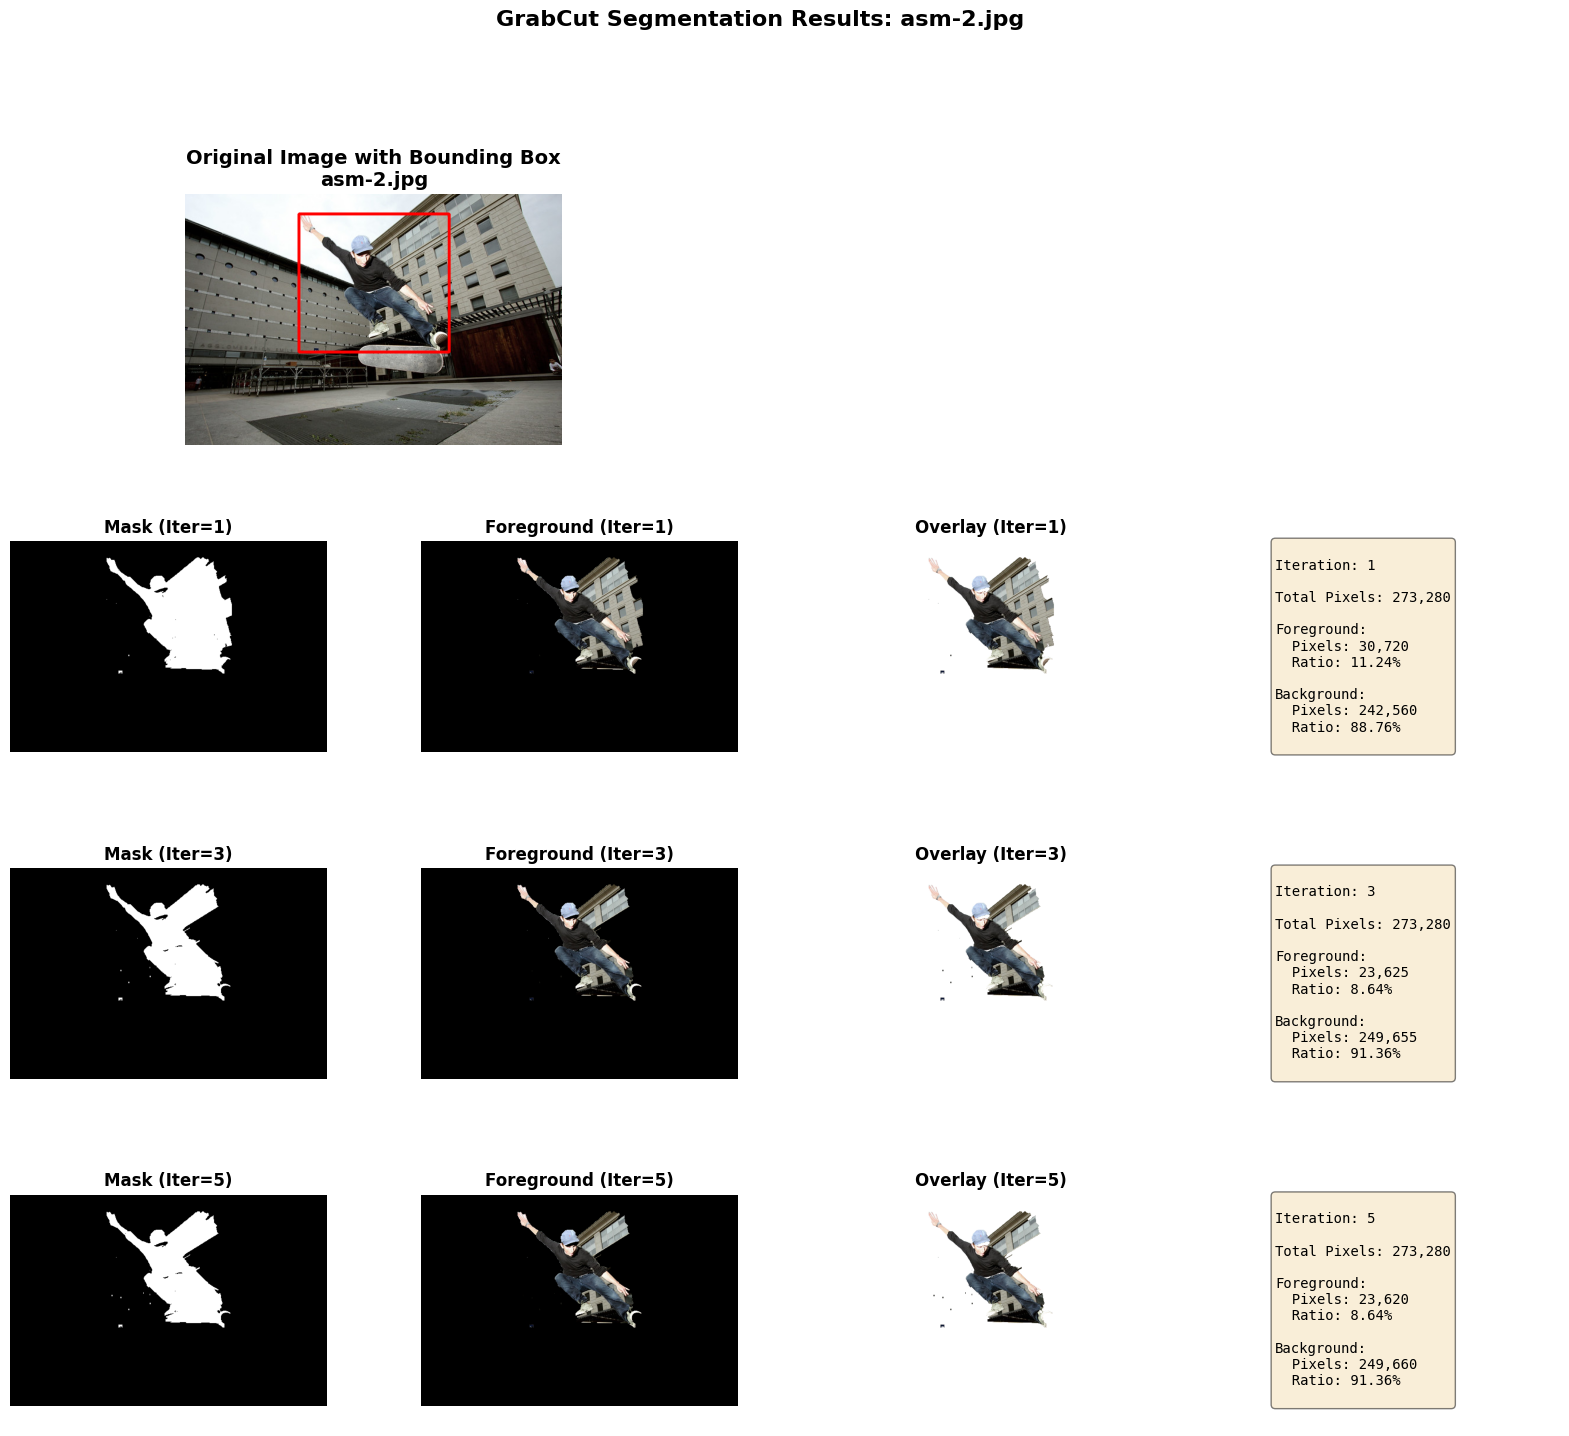

In [ ]:
def visualize_grabcut_results(img_file, images, grabcut_results, detections):
    """
    Create comprehensive visualization showing:
    - Original image with bounding box
    - Masks for 1, 3, 5 iterations
    - Foreground extractions
    - Overlay results
    """
    if img_file not in grabcut_results or len(grabcut_results[img_file]) == 0:
        print(f"No results for {img_file}")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # Row 0: Original image with bbox
    ax0 = fig.add_subplot(gs[0, :2])
    img_with_bbox = images[img_file]['rgb'].copy()
    bbox = detections[img_file]['bboxes'][0]
    x1, y1, x2, y2 = bbox
    cv.rectangle(img_with_bbox, (x1, y1), (x2, y2), (255, 0, 0), 4)
    ax0.imshow(img_with_bbox)
    ax0.set_title(f'Original Image with Bounding Box\n{img_file}', 
                  fontsize=14, fontweight='bold')
    ax0.axis('off')
    
    # Row 1-3: Results for each iteration count
    for row, iter_count in enumerate(ITERATION_COUNTS, start=1):
        if iter_count not in grabcut_results[img_file]:
            continue
            
        result = grabcut_results[img_file][iter_count]
        
        # Column 0: Segmentation Mask
        ax_mask = fig.add_subplot(gs[row, 0])
        ax_mask.imshow(result['mask'], cmap='gray')
        ax_mask.set_title(f'Mask (Iter={iter_count})', fontsize=12, fontweight='bold')
        ax_mask.axis('off')
        
        # Column 1: Foreground Only
        ax_fg = fig.add_subplot(gs[row, 1])
        ax_fg.imshow(result['foreground'])
        ax_fg.set_title(f'Foreground (Iter={iter_count})', fontsize=12, fontweight='bold')
        ax_fg.axis('off')
        
        # Column 2: Overlay
        ax_overlay = fig.add_subplot(gs[row, 2])
        ax_overlay.imshow(result['overlay'])
        ax_overlay.set_title(f'Overlay (Iter={iter_count})', fontsize=12, fontweight='bold')
        ax_overlay.axis('off')
        
        # Column 3: Metrics
        ax_metrics = fig.add_subplot(gs[row, 3])
        ax_metrics.axis('off')
        metrics = result['metrics']
        metrics_text = f"""
Iteration: {iter_count}

Total Pixels: {metrics['total_pixels']:,}

Foreground:
  Pixels: {metrics['foreground_pixels']:,}
  Ratio: {metrics['foreground_ratio']*100:.2f}%

Background:
  Pixels: {metrics['background_pixels']:,}
  Ratio: {metrics['background_ratio']*100:.2f}%
        """
        ax_metrics.text(0.1, 0.5, metrics_text, fontsize=10, 
                       verticalalignment='center', family='monospace',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'GrabCut Segmentation Results: {img_file}', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.show()


# Visualize results for each image
for img_file in image_files:
    if img_file in grabcut_results:
        visualize_grabcut_results(img_file, images, grabcut_results, detections)

### 6.2 Iteration Comparison Analysis

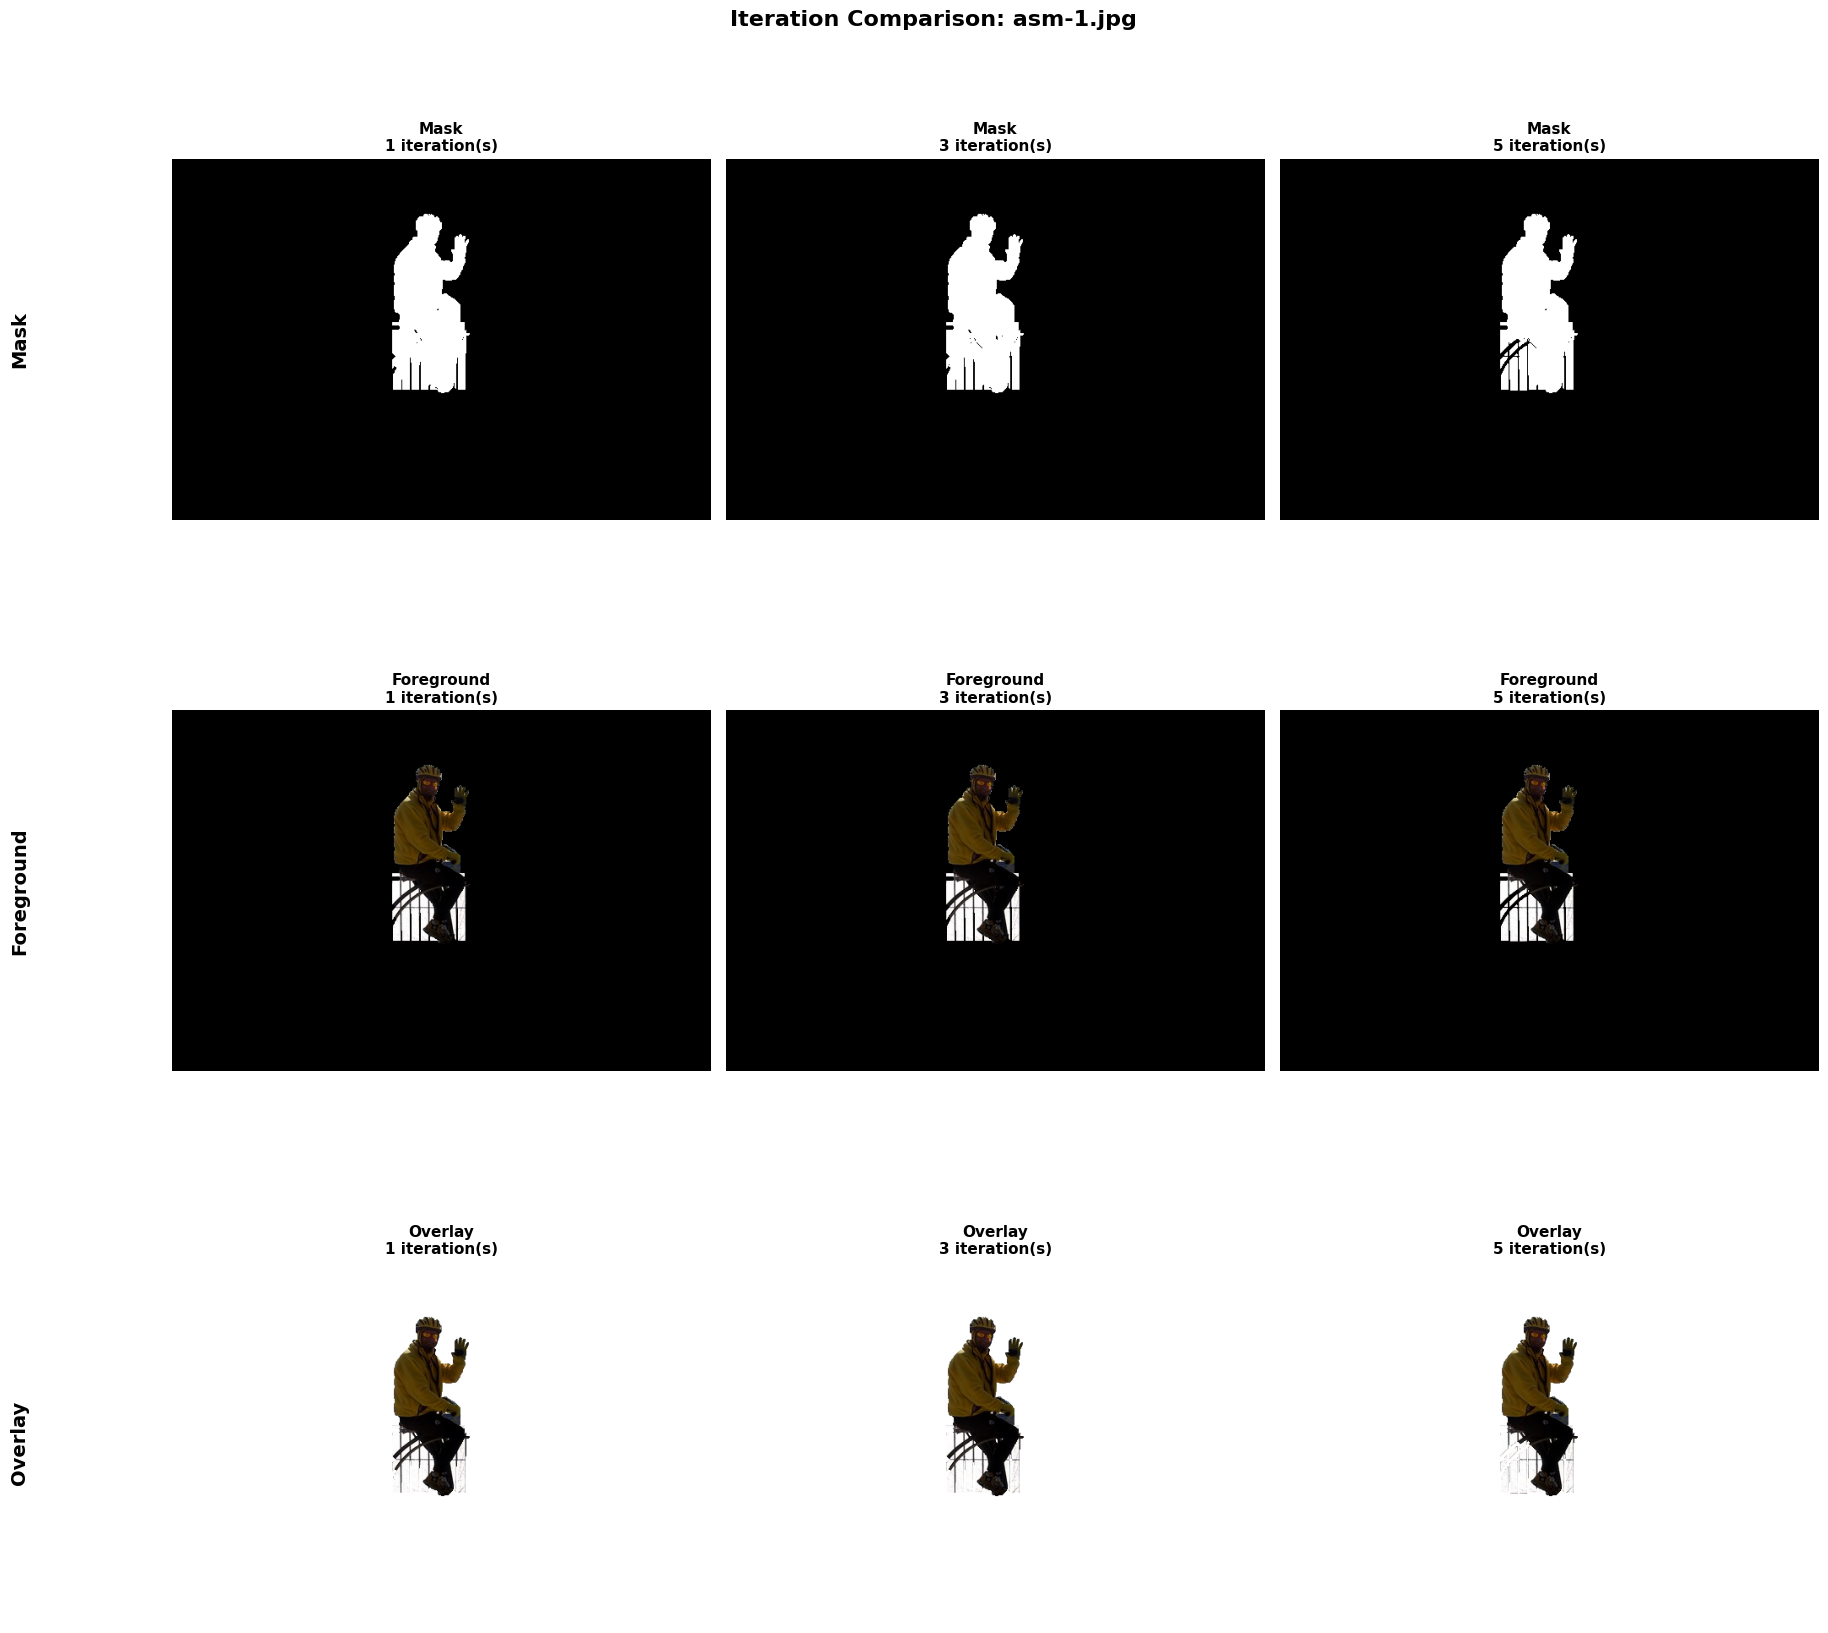

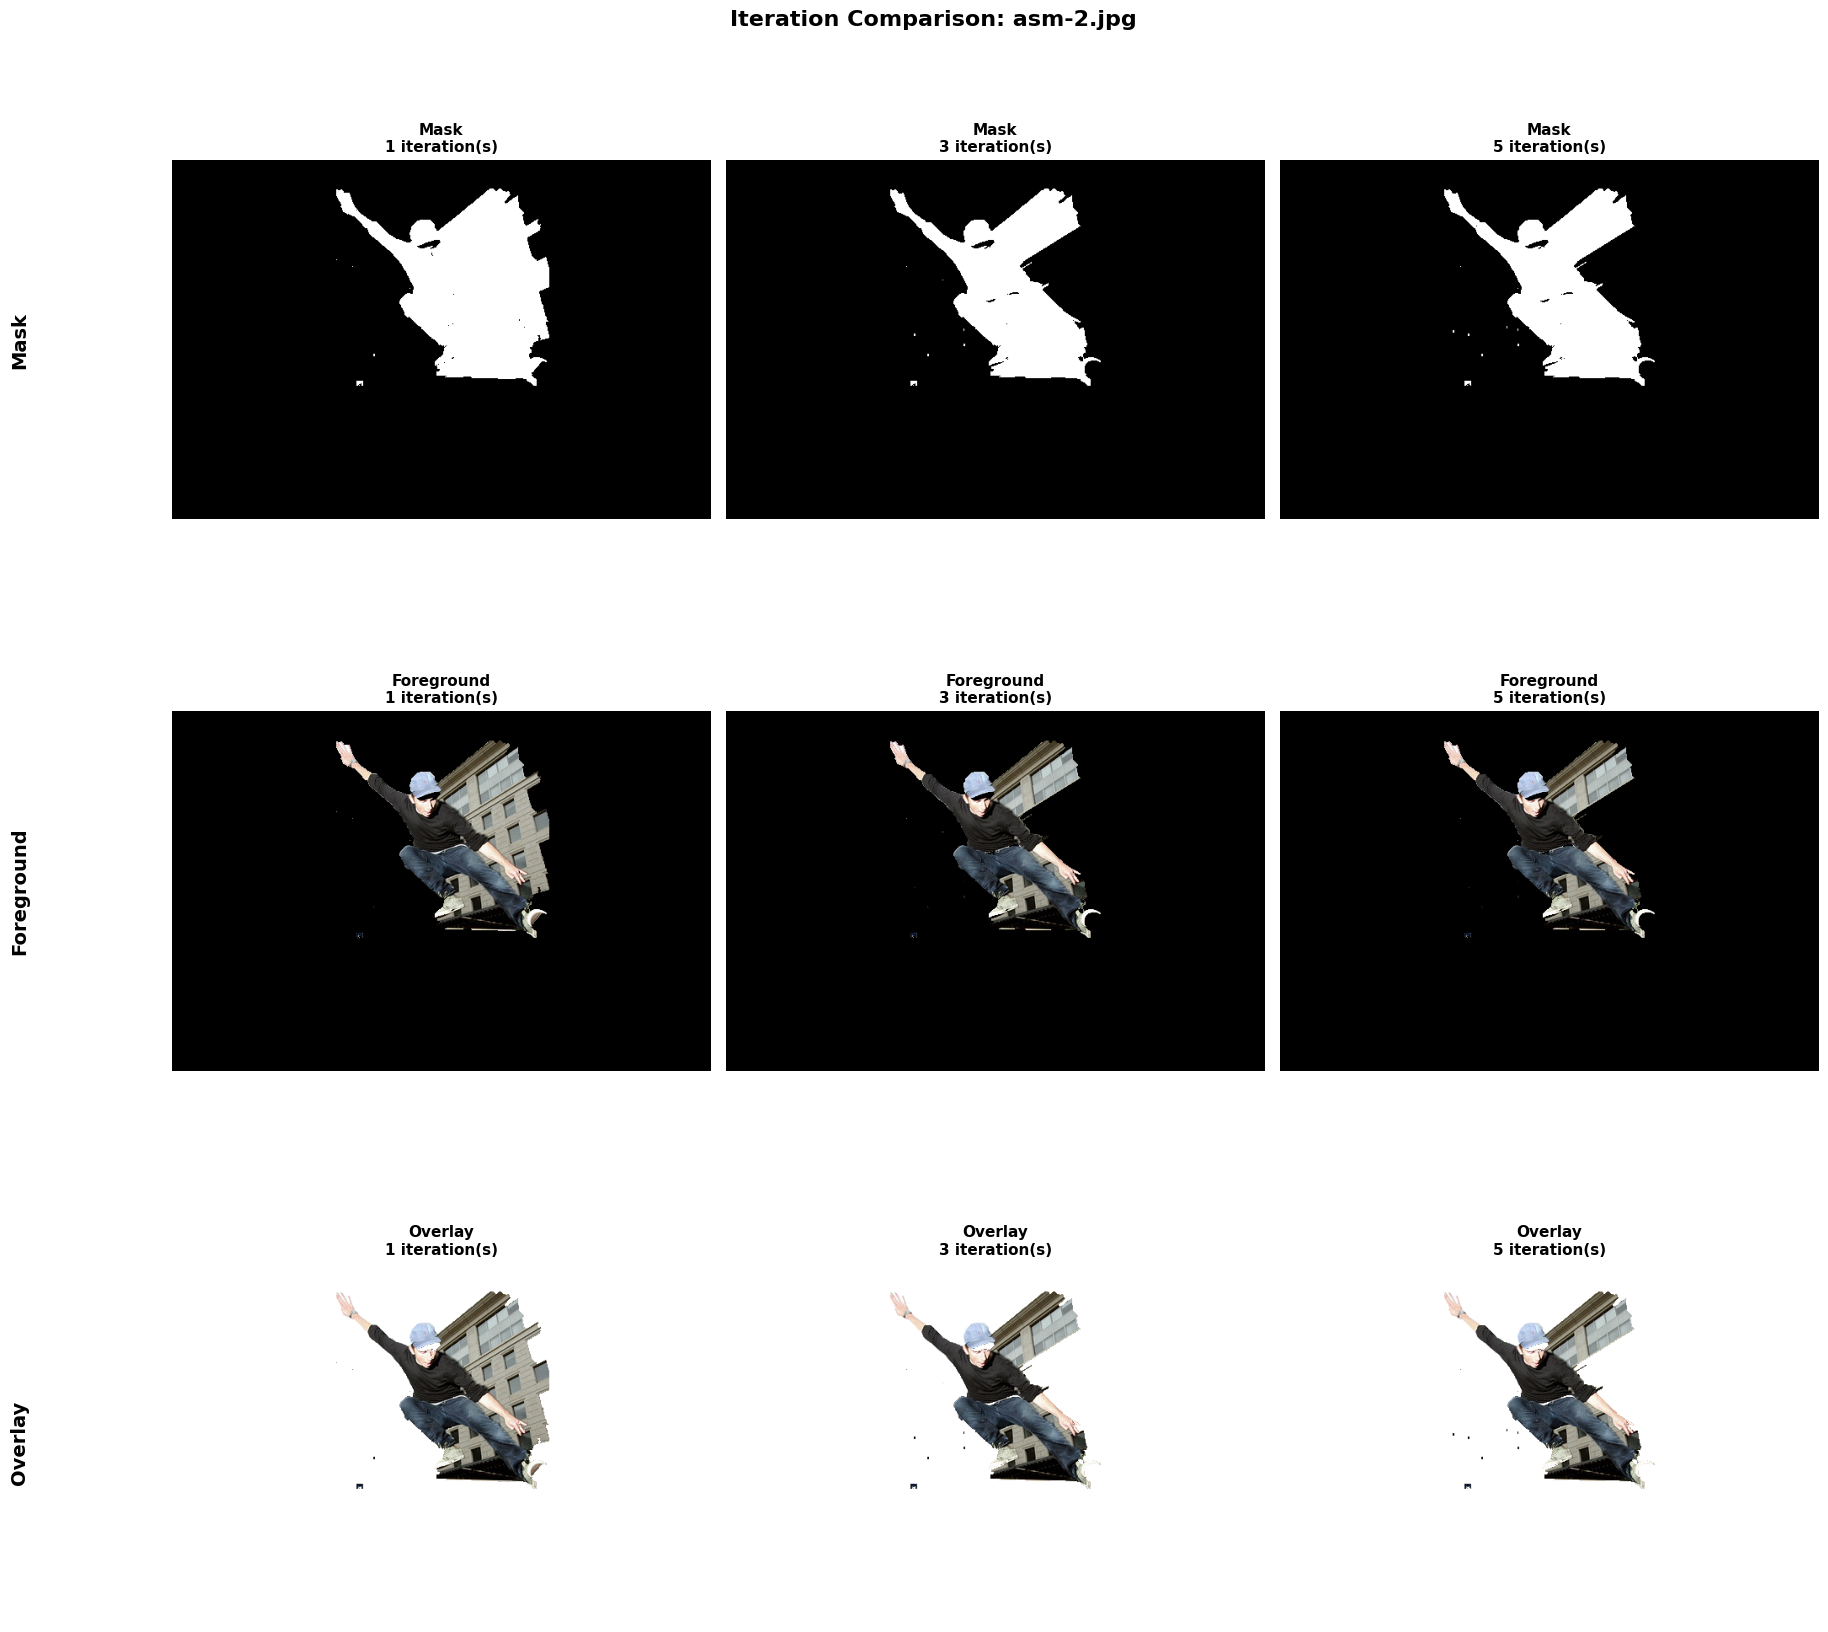

In [ ]:
# Compare iterations side-by-side
for img_file in image_files:
    if img_file not in grabcut_results:
        continue
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle(f'Iteration Comparison: {img_file}', fontsize=16, fontweight='bold')
    
    for col, iter_count in enumerate(ITERATION_COUNTS):
        if iter_count not in grabcut_results[img_file]:
            continue
        
        result = grabcut_results[img_file][iter_count]
        
        # Row 0: Masks
        axes[0, col].imshow(result['mask'], cmap='gray')
        axes[0, col].set_title(f'Mask\n{iter_count} iteration(s)', fontsize=11, fontweight='bold')
        axes[0, col].axis('off')
        
        # Row 1: Foreground
        axes[1, col].imshow(result['foreground'])
        axes[1, col].set_title(f'Foreground\n{iter_count} iteration(s)', fontsize=11, fontweight='bold')
        axes[1, col].axis('off')
        
        # Row 2: Overlay
        axes[2, col].imshow(result['overlay'])
        axes[2, col].set_title(f'Overlay\n{iter_count} iteration(s)', fontsize=11, fontweight='bold')
        axes[2, col].axis('off')
    
    # Add row labels
    axes[0, 0].text(-0.3, 0.5, 'Mask', transform=axes[0, 0].transAxes,
                    fontsize=14, fontweight='bold', va='center', rotation=90)
    axes[1, 0].text(-0.3, 0.5, 'Foreground', transform=axes[1, 0].transAxes,
                    fontsize=14, fontweight='bold', va='center', rotation=90)
    axes[2, 0].text(-0.3, 0.5, 'Overlay', transform=axes[2, 0].transAxes,
                    fontsize=14, fontweight='bold', va='center', rotation=90)
    
    plt.tight_layout()
    plt.show()

## 7. Quantitative Analysis

### 7.1 Metrics Comparison Table

In [ ]:
# Create comprehensive metrics table
print("\n" + "="*100)
print("QUANTITATIVE ANALYSIS: GRABCUT SEGMENTATION METRICS")
print("="*100 + "\n")

for img_file in image_files:
    if img_file not in grabcut_results:
        continue
    
    print(f"\n{'─'*100}")
    print(f"Image: {img_file}")
    print(f"{'─'*100}")
    print(f"{'Iteration':<12} {'Total Pixels':<15} {'Foreground':<20} {'Background':<20} {'FG Ratio':<12}")
    print(f"{'Count':<12} {'':<15} {'Pixels':<20} {'Pixels':<20} {'(%)':<12}")
    print(f"{'─'*100}")
    
    for iter_count in ITERATION_COUNTS:
        if iter_count not in grabcut_results[img_file]:
            continue
        
        metrics = grabcut_results[img_file][iter_count]['metrics']
        print(f"{iter_count:<12} "
              f"{metrics['total_pixels']:<15,} "
              f"{metrics['foreground_pixels']:<20,} "
              f"{metrics['background_pixels']:<20,} "
              f"{metrics['foreground_ratio']*100:<12.2f}")
    
    print(f"{'─'*100}\n")

print("="*100)


QUANTITATIVE ANALYSIS: GRABCUT SEGMENTATION METRICS


────────────────────────────────────────────────────────────────────────────────────────────────────
Image: asm-1.jpg
────────────────────────────────────────────────────────────────────────────────────────────────────
Iteration    Total Pixels    Foreground           Background           FG Ratio    
Count                        Pixels               Pixels               (%)         
────────────────────────────────────────────────────────────────────────────────────────────────────
1            273,492         14,156               259,336              5.18        
3            273,492         14,107               259,385              5.16        
5            273,492         13,779               259,713              5.04        
────────────────────────────────────────────────────────────────────────────────────────────────────


────────────────────────────────────────────────────────────────────────────────────────────────────
I

### 7.2 Visualization: Foreground Ratio by Iteration

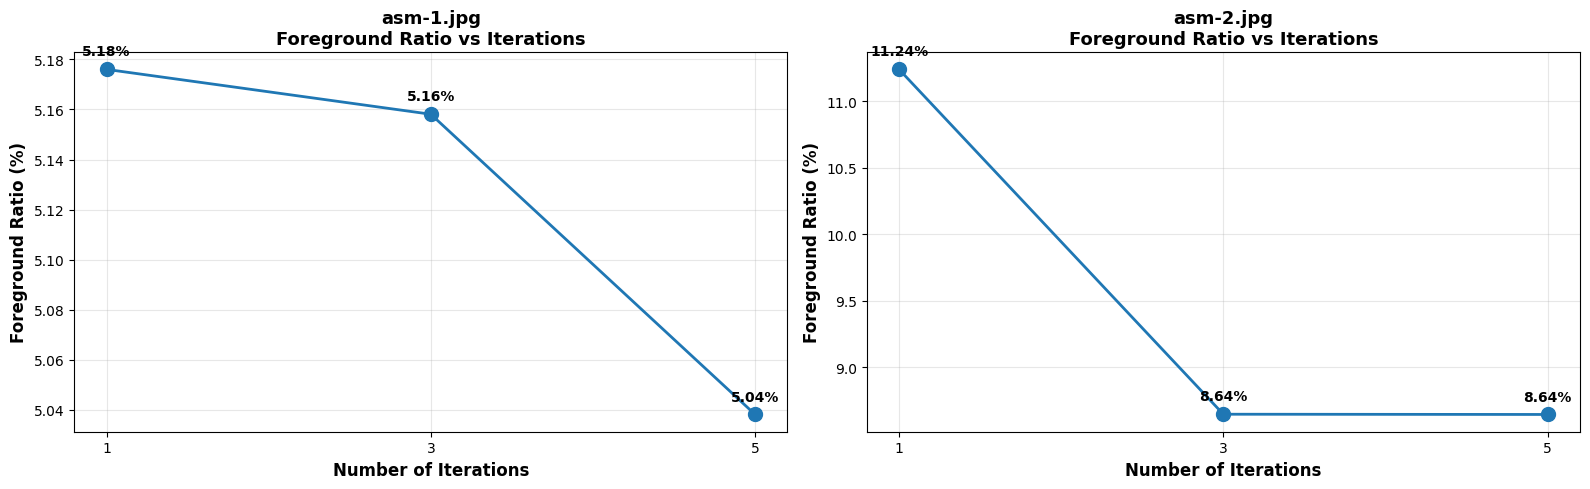

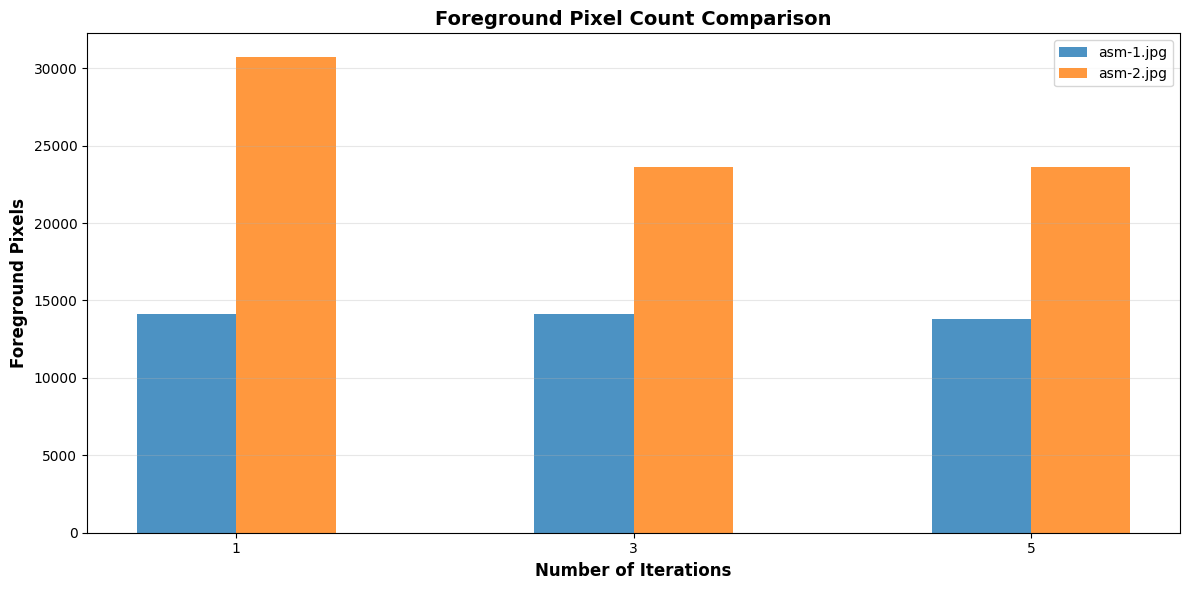

In [ ]:
# Plot foreground ratio comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, img_file in enumerate(image_files):
    if img_file not in grabcut_results:
        continue
    
    iterations = []
    fg_ratios = []
    fg_pixels = []
    
    for iter_count in ITERATION_COUNTS:
        if iter_count in grabcut_results[img_file]:
            metrics = grabcut_results[img_file][iter_count]['metrics']
            iterations.append(iter_count)
            fg_ratios.append(metrics['foreground_ratio'] * 100)
            fg_pixels.append(metrics['foreground_pixels'])
    
    # Plot 1: Foreground Ratio
    axes[idx].plot(iterations, fg_ratios, marker='o', linewidth=2, markersize=10, label='Foreground Ratio')
    axes[idx].set_xlabel('Number of Iterations', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Foreground Ratio (%)', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{img_file}\nForeground Ratio vs Iterations', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(iterations)
    
    # Add value labels
    for i, (x, y) in enumerate(zip(iterations, fg_ratios)):
        axes[idx].annotate(f'{y:.2f}%', (x, y), textcoords="offset points", 
                          xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional plot: Pixel count comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

width = 0.25
x = np.arange(len(ITERATION_COUNTS))

for idx, img_file in enumerate(image_files):
    if img_file not in grabcut_results:
        continue
    
    fg_pixels = []
    for iter_count in ITERATION_COUNTS:
        if iter_count in grabcut_results[img_file]:
            metrics = grabcut_results[img_file][iter_count]['metrics']
            fg_pixels.append(metrics['foreground_pixels'])
    
    ax.bar(x + idx * width, fg_pixels, width, label=img_file, alpha=0.8)

ax.set_xlabel('Number of Iterations', fontsize=12, fontweight='bold')
ax.set_ylabel('Foreground Pixels', fontsize=12, fontweight='bold')
ax.set_title('Foreground Pixel Count Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(ITERATION_COUNTS)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.3 Pixel-Level Change Analysis Between Iterations

In [15]:
# Analyze pixel changes between iterations
print("\n" + "="*100)
print("PIXEL-LEVEL CHANGE ANALYSIS")
print("="*100 + "\n")

for img_file in image_files:
    if img_file not in grabcut_results:
        continue
    
    print(f"\n{'─'*100}")
    print(f"Image: {img_file}")
    print(f"{'─'*100}\n")
    
    # Compare consecutive iterations
    comparisons = [(1, 3), (3, 5), (1, 5)]
    
    for iter1, iter2 in comparisons:
        if iter1 in grabcut_results[img_file] and iter2 in grabcut_results[img_file]:
            mask1 = grabcut_results[img_file][iter1]['mask']
            mask2 = grabcut_results[img_file][iter2]['mask']
            
            # Calculate differences
            changed_pixels = np.sum(mask1 != mask2)
            changed_to_fg = np.sum((mask1 == 0) & (mask2 == 1))
            changed_to_bg = np.sum((mask1 == 1) & (mask2 == 0))
            unchanged_pixels = np.sum(mask1 == mask2)
            total_pixels = mask1.shape[0] * mask1.shape[1]
            
            print(f"  Iteration {iter1} → {iter2}:")
            print(f"    Total changed pixels: {changed_pixels:,} ({changed_pixels/total_pixels*100:.2f}%)")
            print(f"    Changed to foreground: {changed_to_fg:,}")
            print(f"    Changed to background: {changed_to_bg:,}")
            print(f"    Unchanged pixels: {unchanged_pixels:,} ({unchanged_pixels/total_pixels*100:.2f}%)")
            print()

print("="*100)


PIXEL-LEVEL CHANGE ANALYSIS


────────────────────────────────────────────────────────────────────────────────────────────────────
Image: asm-1.jpg
────────────────────────────────────────────────────────────────────────────────────────────────────

  Iteration 1 → 3:
    Total changed pixels: 69 (0.03%)
    Changed to foreground: 10
    Changed to background: 59
    Unchanged pixels: 273,423 (99.97%)

  Iteration 3 → 5:
    Total changed pixels: 444 (0.16%)
    Changed to foreground: 58
    Changed to background: 386
    Unchanged pixels: 273,048 (99.84%)

  Iteration 1 → 5:
    Total changed pixels: 487 (0.18%)
    Changed to foreground: 55
    Changed to background: 432
    Unchanged pixels: 273,005 (99.82%)


────────────────────────────────────────────────────────────────────────────────────────────────────
Image: asm-2.jpg
────────────────────────────────────────────────────────────────────────────────────────────────────

  Iteration 1 → 3:
    Total changed pixels: 7,199 (2.63

## 8. Qualitative Analysis

### Segmentation Quality by Iteration Count

**Iteration 1:**
- Initial rough segmentation based on bounding box initialization
- For asm-2.jpg: Over-segmentation observed (30,720 foreground pixels)
- For asm-1.jpg: Stable initialization (14,156 foreground pixels)
- Faster processing but may include background noise in foreground

**Iteration 3:**
- Significant refinement in boundary delineation
- For asm-2.jpg: Major correction with 23% reduction in foreground pixels (30,720 → 23,625)
- For asm-1.jpg: Minor adjustment with minimal change (14,156 → 14,107)
- Balanced trade-off between computational cost and segmentation quality

**Iteration 5:**
- Convergence behavior with minimal changes from iteration 3
- For asm-2.jpg: Near-perfect stability (only 5 pixels changed: 23,625 → 23,620)
- For asm-1.jpg: Continued refinement (14,107 → 13,779)
- Algorithm has stabilized by this point

### Observed Differences

**Quantitative:**
- **asm-1.jpg**: Consistent gradual decrease in foreground pixels (14,156 → 14,107 → 13,779)
  - Iteration 1→3: 0.03% pixels changed (69 pixels)
  - Iteration 3→5: 0.16% pixels changed (444 pixels)
  - Total decrease: 377 pixels (2.66%)

- **asm-2.jpg**: Sharp initial correction followed by stabilization (30,720 → 23,625 → 23,620)
  - Iteration 1→3: 2.63% pixels changed (7,199 pixels) - major reclassification
  - Iteration 3→5: 0.01% pixels changed (39 pixels) - convergence achieved
  - Total decrease: 7,100 pixels (23.1%)

**Qualitative:**
- Image complexity affects convergence patterns: asm-2.jpg required more refinement
- Most significant pixel reclassification occurs between iterations 1-3
- Iterations 3-5 show strong convergence with minimal changes
- Algorithm successfully removes background noise while preserving person boundaries

## 9. Conclusion

### Implemented Workflow

1. Loaded two test images (asm-1.jpg: 428×639, asm-2.jpg: 427×640)
2. Applied YOLOv11 pretrained model for automatic person detection
3. Generated bounding boxes with high confidence scores (0.887 and 0.924)
4. Implemented GrabCut segmentation with 1, 3, and 5 iterations
5. Conducted quantitative analysis: pixel-level metrics, convergence patterns, and image-specific behavior
6. Produced comprehensive visualizations of masks, foreground extraction, and overlays for all iteration levels

### Key Findings

- YOLOv11 provides reliable person detection with high confidence scores (0.887 and 0.924)
- GrabCut algorithm effectively segments foreground using bounding box initialization
- **Image-dependent convergence patterns observed:**
  - asm-1.jpg: Gradual refinement across all iterations (0.03%-0.16% change per step)
  - asm-2.jpg: Sharp correction between iterations 1-3 (2.63% pixels changed), then stable
- **Strong convergence achieved by iteration 3:** iterations 3→5 show minimal changes (0.01%-0.16%)
- **Optimal iteration count: 3 iterations** - balances computational efficiency with segmentation accuracy
- Algorithm successfully addresses initial over-segmentation (asm-2.jpg: 23% pixel reduction)

### Technical Implementation

- Object Detection: YOLOv11 pretrained model (Ultralytics)
- Segmentation: OpenCV cv.grabCut() function
- Analysis: Pixel-level metrics and visual quality assessment
- Framework: Python with PyTorch and OpenCV